# Project Overview

This is a slightly modified approach to what we worked on in the first three weeks of the Capstone project. Here the list of neighboorhoods which was used for Toronto and New York is replaced by a postal zip codes. The latter was done as a surrogate for the neighborhood definition and allows unified and easy access to all US cities. In addition, the zip code database also includes the latitude and longitudes of the respective area.


# TO DO :
- Check NAN zip codes -> regenerate missing

Odd "outlier" values for lat,long of e.g. San Jose:

603	San Jose	California	62682	40.280	-89.630

604	San Jose	California	87565	35.500	-105.400

606	San Jose	California	95110	37.340	-121.910


- check unique longitutde , latitude values for zip codes
- get optimal value for "k" for KMEANS clustering
-> check DBX values

--> check proximity to original restaurant!

go through identified cluster and examine zipcodes which:
 -> do not have a "Southern / Soul Food Restaurant" venue in the top 10 list
 -> check gegraphical distance
 -> euclidan vector distance
 -> check number of restaurants is below average ? or there are at least some restaurants in the area


### Import libraries


In [1]:
!conda create --name myenv
#activate env
!activate myenv


Solving environment: done

## Package Plan ##

  environment location: /home/wsuser/.conda/envs/myenv



Preparing transaction: done
Verifying transaction: done
Executing transaction: done
#
# To activate this environment, use
#
#     $ conda activate myenv
#
# To deactivate an active environment, use
#
#     $ conda deactivate



In [2]:


!pip install bs4
from bs4 import BeautifulSoup

!pip install uszipcode
from uszipcode import SearchEngine

import numpy as np

import pandas as pd
import requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
!pip install folium
import folium # map rendering library

#!conda install -c conda-forge geopy --yes 
#!pip install goepy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


print ("Libraries imported")

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=8b0a557909d1d71214c4dc720eb0b50fea778c19c1309ed8a88b1035a16fcd59
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.

### Download list of most populated cities in US

In [4]:
# get list of most populous US cities from Wikipedia

url = "https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population"
html = requests.get(url).text


### Extract table with BeautifulSoup

In [5]:

# get all tables with BeautifulSoup
soup = BeautifulSoup(html,"html5lib")

tables = soup.find_all("table")
table_index= -1
table = None

# find the correct table 
for i,table in enumerate(tables):
    if "New York City" in str(table) and "Chicago" in str(table): #
        table_index = i
        #break # first table which 

if table_index >=0:
    table = tables[table_index]
    print ("Table found")
    #print (table)
else:
    print ("No valid table found")
    table = None



Table found


### Extract required data from table and generate a pandas dataframe for cities with at least 1M inhabitants

In [6]:

table_contents=[]

# loop over all cells in the table 
for i,row in enumerate(table.findAll('tr')): # orig: td
    
    #create dictionary for a given cell to be added to dataframe

    if not i:
        #skip header
        continue

    arr = (row.text).split("\n")
    cell = {}

    if len(arr)>17:
        #city 
        cell['City'] = arr[3].split("[")[0]
        #state 
        cell['State'] = arr[5].replace("\xa0","")
        #print (arr)
        cell['Size Estimate'] = int(arr[7].replace(",",""))

        #print (cell)
        
        table_contents.append(cell)

#print(table_contents)
# print(table_contents)
cities = pd.DataFrame(table_contents)

cities.head(10)

,City,State,Size Estimate
0,New York City,New York,8336817
1,Los Angeles,California,3979576
2,Chicago,Illinois,2693976
3,Houston,Texas,2320268
4,Phoenix,Arizona,1680992
5,Philadelphia,Pennsylvania,1584064
6,San Antonio,Texas,1547253
7,San Diego,California,1423851
8,Dallas,Texas,1343573
9,San Jose,California,1021795


### Download zipcode database

In [7]:

#download zip code database
search = SearchEngine(simple_zipcode=True) # simple_zipcode=False


Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!


### Retrieve all zipcodes for cities with 1M or more inhabitants

In [8]:
#cities with at least one million inhabitants
tmpdata = []

for city, state,size in zip(cities["City"],cities["State"],cities["Size Estimate"]):
    if size > 1000000:
        #res = search.by_city_and_state(city, state)
        res = search.by_city(city=city, returns=0)
        if not len(res):
            print ("Error occurred for {}".format(city))
        else:
            #pcode = {}
            print ("Retrieved {} zip codes for {}".format(len(res),city))
            #city_zipcodes[city] = [z.zipcode for z in res]
            for z in res:
                pcode = {'City':city,'State':state,'Zipcode':z.zipcode,'Latitude':z.lat,'Longitude':z.lng}
                tmpdata.append(pcode)
        #break   # REMOVE ------------------------------
city_wzipcodes =  pd.DataFrame(tmpdata)
city_wzipcodes.head()


Retrieved 99 zip codes for New York City
Retrieved 64 zip codes for Los Angeles
Retrieved 58 zip codes for Chicago
Retrieved 106 zip codes for Houston
Retrieved 53 zip codes for Phoenix
Retrieved 56 zip codes for Philadelphia
Retrieved 68 zip codes for San Antonio
Retrieved 36 zip codes for San Diego
Retrieved 63 zip codes for Dallas
Retrieved 32 zip codes for San Jose


,City,State,Zipcode,Latitude,Longitude
0,New York City,New York,10001,40.750,-73.990
1,New York City,New York,10002,40.720,-73.990
2,New York City,New York,10003,40.730,-73.990
3,New York City,New York,10004,40.700,-74.020
4,New York City,New York,10005,40.705,-74.005


### Set up foursquare information

In [9]:
# The code was removed by Watson Studio for sharing.

### Function to retrieve location data from foursquare

In [10]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        #print (url) #REMOVE
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zipcode', 
                  'Zipcode Latitude', 
                  'Zipcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# TO DO --> SOME LATITUDE AND LONGITUDE VALUES ARE MISSING FROM ZIP CODE DATABASE



In [10]:
# TO DO --> SOME LATITUDE AND LONGITUDE VALUES ARE MISSING FROM ZIP CODE DATABASE


In [13]:

#df = city_wzipcodes[city_wzipcodes["City"] == "San Jose"] # REDO REMOVE
df = city_wzipcodes 

df = df.dropna()
print (df.head())
print (df.shape)




            City     State Zipcode  Latitude  Longitude
0  New York City  New York   10001    40.750    -73.990
1  New York City  New York   10002    40.720    -73.990
2  New York City  New York   10003    40.730    -73.990
3  New York City  New York   10004    40.700    -74.020
4  New York City  New York   10005    40.705    -74.005
(572, 5)


In [14]:

df_venues = getNearbyVenues(df["Zipcode"],df["Latitude"] , df["Longitude"], radius=500)
df_venues.head()


,Zipcode,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10001,40.75,-73.99,STORY,40.750866,-73.989272,Gift Shop
1,10001,40.75,-73.99,Louis Vuitton,40.750274,-73.988146,Boutique
2,10001,40.75,-73.99,Krispy Kreme Doughnuts,40.749990,-73.992149,Donut Shop
3,10001,40.75,-73.99,Victoria's Secret,40.749745,-73.987693,Lingerie Store
4,10001,40.75,-73.99,Vans Off The Wall,40.750377,-73.989716,Shoe Store


In [48]:
print (df_venues[df_venues["Zipcode"] == "10026"])

# Amy Ruth's New York
#	Zipcode	1st Most Common Venue	2nd Most Common Venue	3rd Most Common Venue	4th Most Common Venue	5th Most Common Venue	6th Most Common Venue	7th Most Common Venue	8th Most Common Venue	9th Most Common Venue	10th Most Common Venue
#24	10026	Coffee Shop	Park	Southern / Soul Food Restaurant	Deli / Bodega	African Restaurant	Plaza	Speakeasy	Seafood Restaurant	Bagel Shop	Bakery

df.shape

     Zipcode  Zipcode Latitude  Zipcode Longitude  \
1991   10026            40.801            -73.953   
1992   10026            40.801            -73.953   
1993   10026            40.801            -73.953   
1994   10026            40.801            -73.953   
1995   10026            40.801            -73.953   
1996   10026            40.801            -73.953   
1997   10026            40.801            -73.953   
1998   10026            40.801            -73.953   
1999   10026            40.801            -73.953   
2000   10026            40.801            -73.953   
2001   10026            40.801            -73.953   
2002   10026            40.801            -73.953   
2003   10026            40.801            -73.953   
2004   10026            40.801            -73.953   
2005   10026            40.801            -73.953   
2006   10026            40.801            -73.953   
2007   10026            40.801            -73.953   
2008   10026            40.801            -73.

(572, 5)

### One hot encoding of venue information:


In [20]:
# one hot encoding
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add zipcode column back to dataframe
df_onehot['Zipcode'] = df_venues['Zipcode'] 

# move ipcode column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()


,Zipcode,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zoo Exhibit
0,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### group rows by zip code and by taking the mean of the frequency of occurrence of each category


In [89]:
df_grouped = df_onehot.groupby('Zipcode').mean().reset_index()
print (df_grouped.head())
print (df_grouped.shape)


  Zipcode  ATM  Accessories Store  Adult Boutique  Advertising Agency  \
0   00690  0.0                0.0             0.0                 0.0   
1   10001  0.0                0.0             0.0                 0.0   
2   10002  0.0                0.0             0.0                 0.0   
3   10003  0.0                0.0             0.0                 0.0   
4   10004  0.0                0.0             0.0                 0.0   

   Afghan Restaurant  African Restaurant  Airport  Airport Food Court  \
0                0.0                 0.0      0.0                 0.0   
1                0.0                 0.0      0.0                 0.0   
2                0.0                 0.0      0.0                 0.0   
3                0.0                 0.0      0.0                 0.0   
4                0.0                 0.0      0.0                 0.0   

   Airport Lounge  ...  Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  \
0             0.0  ...                 0.0 

In [90]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### top 10 venues for each neighborhood.


In [91]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zipcodes_venues_sorted = pd.DataFrame(columns=columns)
zipcodes_venues_sorted['Zipcode'] = df_grouped['Zipcode']

for ind in np.arange(df_grouped.shape[0]):
    zipcodes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

zipcodes_venues_sorted.head()

#zipcodes_venues_sorted[zipcodes_venues_sorted["Zipcode"]=="10026"].head()



,Zipcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,00690,Coworking Space,Caribbean Restaurant,Pizza Place,Zoo Exhibit,Financial or Legal Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory
1,10001,Korean Restaurant,Hotel,Coffee Shop,Gym / Fitness Center,Burger Joint,American Restaurant,Boxing Gym,Cosmetics Shop,Bakery,Clothing Store
2,10002,Cocktail Bar,Asian Restaurant,Café,Hotel,Pizza Place,Bar,Coffee Shop,Wine Bar,Ice Cream Shop,Art Gallery
3,10003,Coffee Shop,Japanese Restaurant,Italian Restaurant,Grocery Store,Dessert Shop,Ice Cream Shop,Café,Wine Shop,Pet Store,Sushi Restaurant
4,10004,Park,Pier,Historic Site,Harbor / Marina,Gym / Fitness Center,Snack Place,Monument / Landmark,Boat or Ferry,American Restaurant,Farm


### cluster neighborhoods


10
20
30


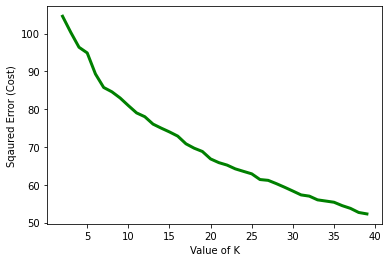

array([29, 25, 25, 25, 25, 25, 25, 25,  7,  7], dtype=int32)

In [92]:
import matplotlib.pyplot as plt 

# set number of clusters
cost =[]
k_values = [i for i in range(2,40)]

df_grouped_clustering = df_grouped.drop('Zipcode', 1)
#print (toronto_grouped_clustering.head())
# run k-means clustering
for kclusters in k_values:
    if kclusters %10==0 and kclusters > 0:
        print (kclusters)
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)
    #print (dir(kmeans))
    #print (kmeans.inertia_)
    cost.append(kmeans.inertia_)
    
# plot the cost against K values
plt.plot(k_values, cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

### re-cluster with appropriate "k"-value

In [93]:
kmeans = KMeans(n_clusters=100, random_state=0).fit(df_grouped_clustering)


### create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [94]:
# add clustering labels
zipcodes_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df_merged = df

# merge df_grouped with df_data to add latitude/longitude for each zipcode
df_merged = df_merged.join(zipcodes_venues_sorted.set_index('Zipcode'), on='Zipcode')

# DBX -> FIX
df_merged = df_merged.dropna()

df_merged.head(20) # check the last columns!

,City,State,Zipcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New York City,New York,10001,40.750,-73.990,1.0,Korean Restaurant,Hotel,Coffee Shop,Gym / Fitness Center,Burger Joint,American Restaurant,Boxing Gym,Cosmetics Shop,Bakery,Clothing Store
1,New York City,New York,10002,40.720,-73.990,1.0,Cocktail Bar,Asian Restaurant,Café,Hotel,Pizza Place,Bar,Coffee Shop,Wine Bar,Ice Cream Shop,Art Gallery
2,New York City,New York,10003,40.730,-73.990,1.0,Coffee Shop,Japanese Restaurant,Italian Restaurant,Grocery Store,Dessert Shop,Ice Cream Shop,Café,Wine Shop,Pet Store,Sushi Restaurant
3,New York City,New York,10004,40.700,-74.020,0.0,Park,Pier,Historic Site,Harbor / Marina,Gym / Fitness Center,Snack Place,Monument / Landmark,Boat or Ferry,American Restaurant,Farm
4,New York City,New York,10005,40.705,-74.005,1.0,Coffee Shop,American Restaurant,Seafood Restaurant,Cocktail Bar,Pizza Place,Café,Italian Restaurant,Wine Shop,Restaurant,Food Truck
5,New York City,New York,10006,40.708,-74.013,1.0,Coffee Shop,Pizza Place,Hotel,Memorial Site,Park,Bar,Steakhouse,Wine Shop,Gourmet Shop,Gym / Fitness Center
6,New York City,New York,10007,40.714,-74.008,1.0,Coffee Shop,Sandwich Place,Park,Italian Restaurant,Gym / Fitness Center,Gym,Clothing Store,Bakery,Spa,Toy / Game Store
7,New York City,New York,10009,40.730,-73.980,57.0,Bar,Pizza Place,Bagel Shop,Mexican Restaurant,Italian Restaurant,Vietnamese Restaurant,Ice Cream Shop,Coffee Shop,Park,Ramen Restaurant
8,New York City,New York,10010,40.730,-73.980,57.0,Bar,Pizza Place,Bagel Shop,Mexican Restaurant,Italian Restaurant,Vietnamese Restaurant,Ice Cream Shop,Coffee Shop,Park,Ramen Restaurant
9,New York City,New York,10011,40.740,-74.000,1.0,Coffee Shop,Gym / Fitness Center,American Restaurant,Italian Restaurant,Bakery,Grocery Store,Café,Ice Cream Shop,Cosmetics Shop,New American Restaurant


### compare neigbhorhoods of a specific city as well as with neighborhoods in different cities


In [96]:
# compare cluster IDs of neighborhoods
# --> REMOVE ???

zips = list(df_merged["Zipcode"])
vals = []

diff_n = 0
same_n = 0

for i1 in range(0,len(zips)):
    #print (zips[i1])
    #print (i1)
    for i2 in range(i1+1,len(zips)):
    
        #print (zips[i1],zips[i2])
        x1 =  df_merged[df_merged["Zipcode"]==zips[i1]]
        x2 =  df_merged[df_merged["Zipcode"]==zips[i2]]
        # append identical city, cluster labels
        #vals.append([ (x1["City"].values)[0] == (x2["City"].values)[0] , (x1["Cluster Labels"].values)[0] == (x2["Cluster Labels"].values)[0] ])
        
        #if (x1["City"].values)[0] == (x2["City"].values)[0] :
            

        #break
        if i2> 20: #REMOVE --------------------
            break
    break
#print (vals)
            

In [97]:
# compare distance (Euclidean distance) between neighborhoods

### Find cluster information for respective zipcode

In [98]:
# Venuue type -> "Southern / Soul Food Restaurant"
#print (info)

cluster_nr =   ((df_merged[df_merged["Zipcode"]=="10026"])["Cluster Labels"].values )[0]

print (cluster_nr)


1.0


In [102]:
cluster = df_merged[df_merged["Cluster Labels"]==cluster_nr]

print (cluster.shape)

cluster.head()



(133, 16)


,City,State,Zipcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New York City,New York,10001,40.750,-73.990,1.0,Korean Restaurant,Hotel,Coffee Shop,Gym / Fitness Center,Burger Joint,American Restaurant,Boxing Gym,Cosmetics Shop,Bakery,Clothing Store
1,New York City,New York,10002,40.720,-73.990,1.0,Cocktail Bar,Asian Restaurant,Café,Hotel,Pizza Place,Bar,Coffee Shop,Wine Bar,Ice Cream Shop,Art Gallery
2,New York City,New York,10003,40.730,-73.990,1.0,Coffee Shop,Japanese Restaurant,Italian Restaurant,Grocery Store,Dessert Shop,Ice Cream Shop,Café,Wine Shop,Pet Store,Sushi Restaurant
4,New York City,New York,10005,40.705,-74.005,1.0,Coffee Shop,American Restaurant,Seafood Restaurant,Cocktail Bar,Pizza Place,Café,Italian Restaurant,Wine Shop,Restaurant,Food Truck
5,New York City,New York,10006,40.708,-74.013,1.0,Coffee Shop,Pizza Place,Hotel,Memorial Site,Park,Bar,Steakhouse,Wine Shop,Gourmet Shop,Gym / Fitness Center


In [105]:
# DBX TO DO: go through list and identify zip codes in cluster which:
# -> do not have a "Southern / Soul Food Restaurant" venue in the top 10 list
# -> check gegraphical distance
# -> euclidan vector distance
# -> check number of restaurants is below average ? or there are at least some restaurants in the area



### display cluster information of zip codes on map


In [ ]:
# create map
address = 'San Jose, California'

geolocator = Nominatim(user_agent="us_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Zipcode'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[(int(cluster))-1],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters